In [91]:
import random
import matplotlib.pyplot as plt
import h5py
import numpy as np

from OxCaptcha import OxCaptcha
import torch
import pyprob
from pyprob import Model
from pyprob.distributions import Distribution, Categorical, Normal

In [170]:
def render_facebook_captcha(letters, file_name=None):
    width, height = 200, 50
    o = OxCaptcha(width, height)
    o.background()

    fonts = ['/usr/share/fonts/truetype/noto/NotoSans-Regular.ttf',
             '/usr/share/fonts/truetype/ubuntu/Ubuntu-R.ttf',
             '/usr/share/fonts/truetype/hind/Hind-SemiBold.ttf']
    font = random.choice(fonts)
    font_size = random.randint(38, 44)
    o.font(font, font_size)

    x_offset = random.randint(5, 15)
    y_offset = random.randint(-3, 2)
    kerning = random.randint(-2, 1)
    o.text(letters, x_offset, y_offset, kerning)
    
    alpha = random.randint(10, 20)
    o.distortion_elastic(alpha, 11, 6)

    x_phase = random.randint(0, width)
    x_period = random.randint(10, 40)
    x_amplitude = random.randint(-4, 4)
    y_phase = random.randint(0, height)
    y_period = random.randint(5, 20)
    y_amplitude = random.randint(-5, 5)
    o.distortion_shear(x_phase, x_period, x_amplitude, y_phase, y_period, y_amplitude)

    strokes = random.randint(6, 11)
    width = random.randint(0, 3)
    o.noise_strokes(strokes, 0)

    ellipses = random.randint(4, 7)
    width = random.randint(0, 3)
    o.noise_ellipses(ellipses, width)
    
    o.noise_white_gaussian(10)
    
    if file_name is not None:
        o.save(file_name)
    
    return o.as_array()

random_projection_matrices = h5py.File('../resources/random-projection-matrices.h5', 'r')
rpm10000to500 = np.asarray(random_projection_matrices['R10000-500'])

def reduce_dim(image):
    return np.matmul(rpm10000to500, image.flatten())

class ABCDistribution(Distribution):
    def __init__(self, rendered_image, sigma):
        self._rendered_image = rendered_image
        self._sigma = sigma
        super().__init__(name='ABCDistribution')

    
    def sample(self):
        return self._rendered_image
    
    def log_prob(self, observed_image, sum):
        r = reduce_dim(self._rendered_image)
        o = reduce_dim(observed_image)
        return Normal(r, self._sigma).log_prob(o, sum=sum)

In [171]:
class FacebookCaptcha(Model):
    def __init__(self, letters='abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ123456789', abc_sigma=1):
        self._letters = letters
        self._abc_sigma = abc_sigma
        super().__init__('FacebookCaptcha')
        
    def forward(self):
        num_letters = pyprob.sample(Categorical(torch.tensor([0,0,0,0,0,0,1,1,1])), name='num_letters')
        letters = []
        for i in range(num_letters):
            j = pyprob.sample(Categorical(torch.ones(len(self._letters))), name='letter_{}'.format(i))
            letter = self._letters[j]
            letters.append(letter)
        letters = ''.join(letters)
        
        pyprob.tag(letters, name='letters')
            
        rendered_image = render_facebook_captcha(letters)
        pyprob.tag(rendered_image, name='rendered_image')
        
        pyprob.observe(ABCDistribution(rendered_image, self._abc_sigma), name='observed_image')
        
model = FacebookCaptcha()
model.forward()

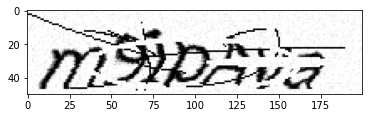

In [191]:
ground_truth_trace = model.sample()
ground_truth_image = ground_truth_trace['rendered_image']
plt.imshow(ground_truth_image, cmap='gray')

In [ ]:
posterior = model.posterior(observe={'observed_image': gt_image}, num_traces=10)

Time spent  | Time remain.| Progress             | Trace | ESS  | Traces/sec


In [ ]:
posterior_letters = posterior.map(lambda trace: trace['letters'])

In [ ]:
plt.hist(posterior_letters.values, weights=posterior_letters.weights_numpy())
plt.xticks(rotation=45)
plt.show()